In [1]:
import rebound
import reboundx
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from collections import OrderedDict
from numpy.random import seed, normal, uniform

def wrap(val):
    while val < 0:
        val += 2*np.pi
    while val > 2*np.pi:
        val -= 2*np.pi
    return val*180/np.pi

In [2]:
def output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2):
    ps = sim.particles
    for p in planets:
        try:
            e[p].append(ps[p].e)
            P[p].append(ps[p].P)
            pomega[p].append(ps[p].pomega)
            longitude[p].append(ps[p].l)  
            t[p].append(sim.t)
        except:
            pass
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        try:
            Pratio[pair].append(ps[p2].P/ps[p1].P)
            t[pair].append(sim.t)
            if resonance[1] is not None:
                res = resonance[1]
                p = res[1]
                q = res[0]-res[1]
                phi1[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p2].pomega))
                phi2[pair].append(wrap((p+q)*ps[p2].l - p*ps[p1].l - q*ps[p1].pomega))
        except:
            pass

In [3]:
def plot(t,P,e,Pratio,phi1,phi2,planets,resonances):
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(18,10))
    for p in planets:
        axarr[0,0].plot(t[p], P[p], '.', label=p)
        axarr[0,1].plot(t[p], e[p], '.', label=p)
    for resonance in resonances.items():
        pair = resonance[0]
        res = resonance[1]
        axarr[1,0].plot(t[pair], Pratio[pair], '.', label=pair)
        if res is not None:
            resratio = res[0]/res[1]
            axarr[1,1].plot(t[pair], np.array(Pratio[pair])-resratio, '.', label=pair)
            axarr[2,0].plot(t[pair], phi1[pair], '.', label=pair)
            axarr[2,1].plot(t[pair], phi2[pair], '.', label=pair)
            axarr[2,0].set_ylim([0.,360])
            axarr[2,1].set_ylim([0.,360])
    for ax in axarr.flatten():
        ax.legend(loc='upper right')
    return fig

In [4]:
def removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances): # Tremovel in # of taue0s
    ps = sim.particles
    taue0 = ps[-1].params["tau_e"]
    T0 = sim.t
    print(T0)
    T = abs(taue0)*Tremoval
    Nout = 1000
    times = np.linspace(T0, T0+T, Nout)
    
    for i, time in enumerate(times):
        for p in ps[1:]:
            p.params["tau_e"] = taue0/(1.-(sim.t-T0)/T)
            try: # try except so we don't assign a tau_a to planets that don't have it
                has_tau_a = p.params["tau_a"]
                p.params["tau_a"] = taue0*K/(1.-(sim.t-T0)/T)
            except:
                pass
        sim.integrate(time)
        output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
    for p in ps[1:]:
        p.params["tau_e"] = np.inf
        p.params["tau_a"] = np.inf

def integrate(sim, T, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances):
    Nout = 1000
    T0 = sim.t
    times = np.linspace(T0, T0+T, Nout)
    ps = sim.particles
    for i, time in enumerate(times):
        sim.integrate(time)
        output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
        
def initialize(planets, resonances):
    t, e, P, pomega, longitude, Pratio, phi1, phi2 = {}, {}, {}, {}, {}, {}, {}, {}

    for label in planets:
        t[label] = []
        e[label] = []
        P[label] = []
        pomega[label] = []
        longitude[label] = []

    for pair in resonances.keys():
        t[pair] = []
        Pratio[pair] = []
        phi1[pair] = []
        phi2[pair] = []
        
    return t, e, P, pomega, longitude, Pratio, phi1, phi2

In [5]:
def drawnormal(pair):
    mean, sigma = pair
    val = -1
    while val < 0:
        val = normal(mean, sigma)
    return val

In [6]:
def res_chain_setup(sim, planets, resonances, delta):
    masses, incs, Omegas, thetas = {}, {}, {}, {}

    for p in planets:
        masses[p] = drawnormal(massdist[p])
        print(masses[p])
        incs[p] = drawnormal(incdist[p])
        print(incs[p])
        Omegas[p] = uniform(0,2*np.pi)
        thetas[p] = uniform(0,2*np.pi)

    ps = sim.particles
    sim.add(m=1.)
    
    p0 = planets[0]
    sim.add(m=masses[p0],a=1., inc=incs[p0], Omega=Omegas[p0], theta=thetas[p0], hash=p0)
    
    for resonance in resonances.items():
        pair = resonance[0]
        p1 = pair[0]
        p2 = pair[1]
        res = resonance[1]
        p = res[1]
        q = res[0]-res[1]
        sim.add(m=masses[p2],P=(p+q)/p*sim.particles[-1].P*(1.+delta), inc=incs[p2], Omega=Omegas[p2], theta=thetas[p2], hash=p2)
        
    sim.move_to_com() # Moves to the center of momentum frame

In [7]:
incdist = {'b':[89.65,0.27], 'c':[89.67, 0.17], 'd':[89.75,0.16], 'e':[89.86, 0.12], 'f':[89.68,0.034], 'g':[89.710,0.025]}
for inc in incdist.values():
    inc[0] = (90-inc[0])*np.pi/180.
    inc[1] *= np.pi/180.

    massdist = {'b':[0.85,0.72], 'c':[1.38,0.61], 'd':[0.41,0.27], 'e':[0.62,0.58], 'f':[0.68,0.18], 'g':[1.34,0.88]}
Mearth = 3.e-6
Mstar = 0.08
for mass in massdist.values():
    mass[0] *= Mearth/Mstar
    mass[1] *= Mearth/Mstar

In [8]:
planets = ['d', 'e', 'f', 'g']
resonances = OrderedDict([(('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3))]) # ordered so we add planets in right sequence

simID=0
seed(simID)
K = 10**uniform(1,3)
print(K)

125.20653814999461


2.2883616375692762e-05
0.008699876321470346
4.920751829213005e-06
0.006569261068495397
3.404630007654001e-05
0.005284860424649559
6.623230108598195e-05
0.005314152535408878


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


CPU times: user 1min 1s, sys: 15 ms, total: 1min 1s
Wall time: 1min 1s


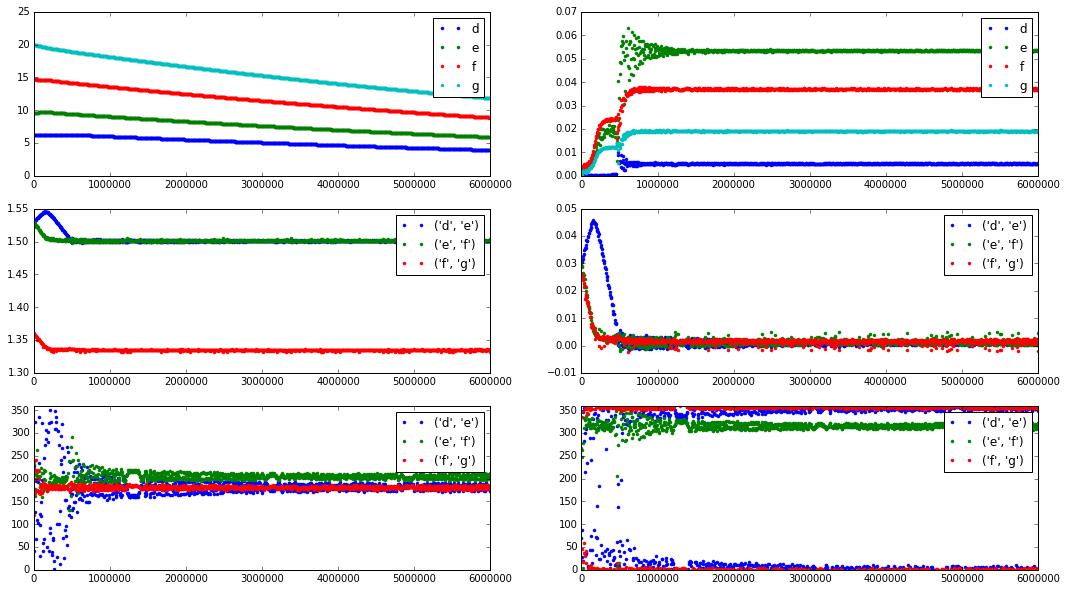

In [9]:
%%time
sim = rebound.Simulation()
ps = sim.particles

rebx = reboundx.Extras(sim)
params = rebx.add("modify_orbits_forces")

delta=2.e-2 # fractional distance to start beyond resonance. Would be better to calculate relative to width of resonance

res_chain_setup(sim, planets, resonances, delta)

sim.integrator="whfast"
sim.dt=ps[1].P/20.

t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)

taua = 1.e7
taue = taua/K

for p in ps[1:]:
    p.params["tau_e"] = -taue
ps['g'].params["tau_a"] = -taua

T = taua*delta*30
Nout = 1000

times = np.linspace(sim.t,sim.t+T,Nout)
for i, time in enumerate(times):
    sim.integrate(time)
    output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

6000000.0


/mnt/raid-cita/dtamayo/rebound/rebound/simulation.py:508: RuntimeWarning: REBOUNDx: Passing a velocity-dependent force to WHFAST. Need to apply as an operator.
  warnings.warn(msg[1:], RuntimeWarning)


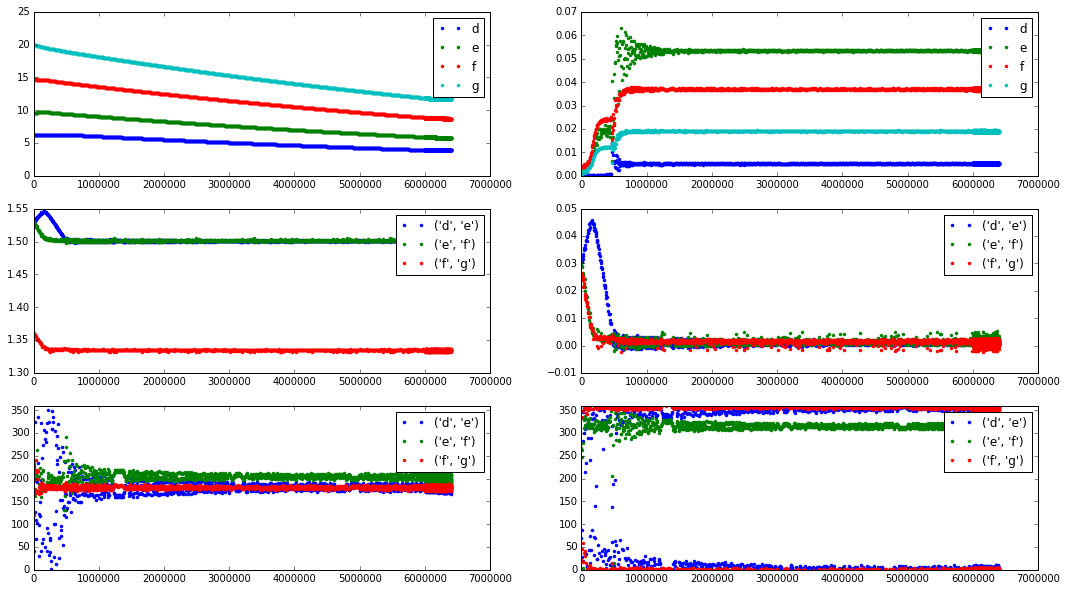

In [10]:
Tremoval = 5 # number of taue0s over which to remove damping
removedamping(sim, Tremoval, K, t, e, P, pomega, longitude, Pratio, phi1, phi2,planets,resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [11]:
from random import seed, uniform

Pb = 1.511/365.25
Pc = 2.4218/365.25
Pg = 12.353/365.25

mscale = Mstar/sim.particles[0].m
Pscale = Pg/sim.particles[-1].P

sim2 = rebound.Simulation()
sim2.G = 4*np.pi**2
sim2.add(m=Mstar)
sim2.add(m=1.e-9, P=Pb, inc=drawnormal(incdist['b']), Omega = uniform(0,2*np.pi), theta=uniform(0,2*np.pi), hash='b')
sim2.add(m=1.e-9, P=Pc, inc=drawnormal(incdist['c']), Omega = uniform(0,2*np.pi), theta=uniform(0,2*np.pi), hash='c')

for p in planets:
    p1 = sim.particles[p]
    sim2.add(m=p1.m*mscale, P=p1.P*Pscale, e=p1.e, inc=p1.inc, pomega=p1.pomega, Omega=p1.Omega, theta=p1.theta, hash=p)

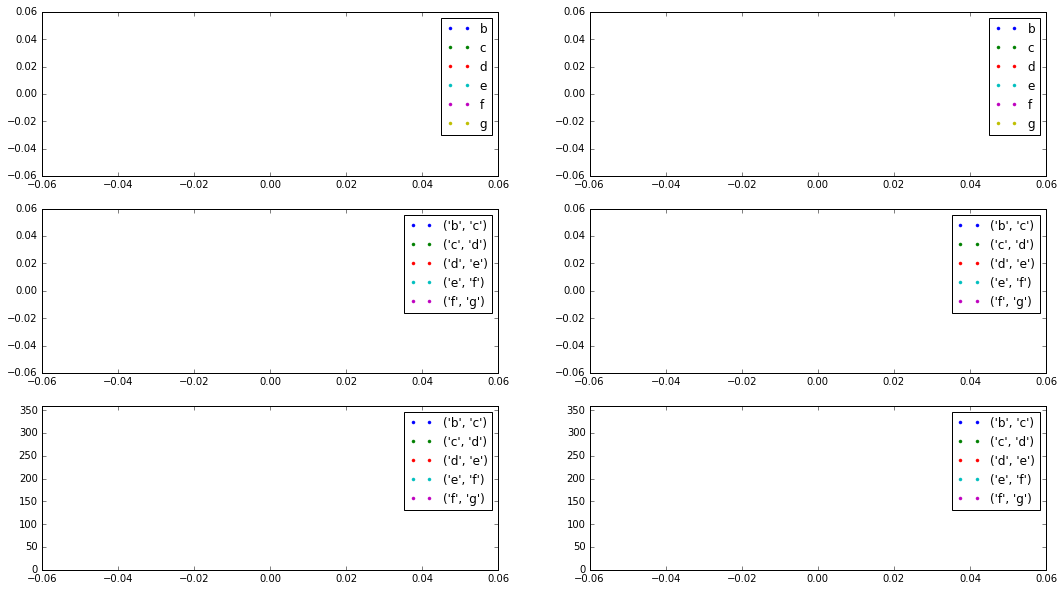

In [12]:
sim = sim2
ps = sim.particles
sim.integrator="whfast"
sim.dt=ps[1].P*0.07

planets = ['b', 'c', 'd', 'e', 'f', 'g']
resonances = OrderedDict([(('b','c'),(8,5)), (('c','d'),(5,3)), (('d','e'),(3,2)),(('e','f'),(3,2)),(('f','g'),(4,3))]) # ordered so we add planets in right sequence
t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
  
#integrate(sim, 1.e5*ps[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

CPU times: user 5.99 s, sys: 18 ms, total: 6 s
Wall time: 6.03 s


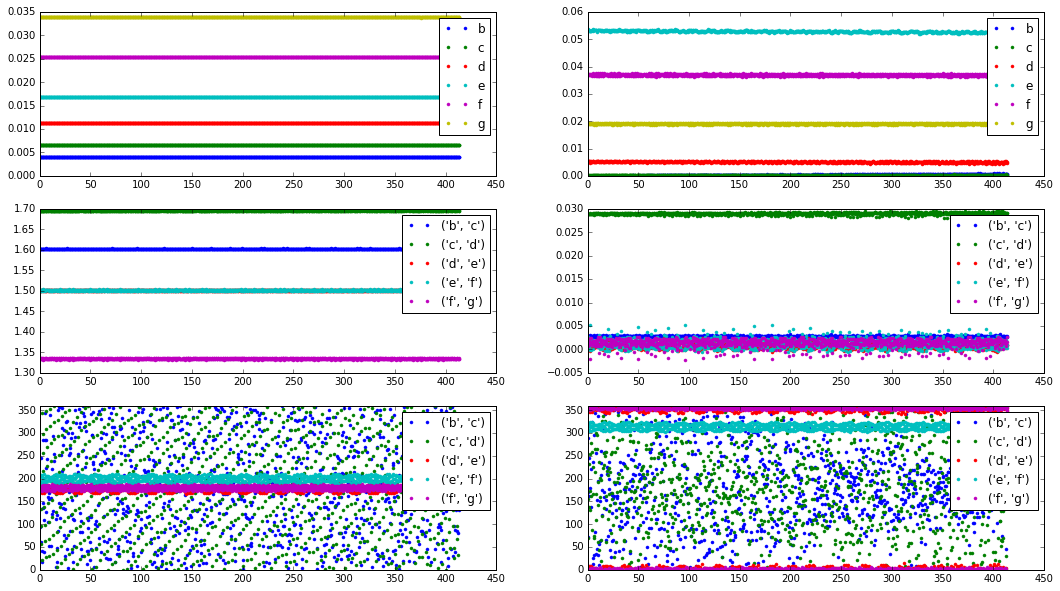

In [13]:
%%time
T0 = sim.t
T = 1e5*ps[1].P
Nout = 1000
times = np.linspace(T0, T0+T, Nout)
    
Mb = drawnormal(massdist['b'])*mscale
Mc = drawnormal(massdist['c'])*mscale
for i, time in enumerate(times):
    ps['b'].m = Mb*(sim.t-T0)/T
    ps['c'].m = Mc*(sim.t-T0)/T
        
    sim.integrate(time)
    output(sim,planets,resonances,t,e,P,pomega,longitude,Pratio,phi1,phi2)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [14]:
sim.save("test.bin")

In [30]:
sim = rebound.Simulation.from_file("test.bin")
ps = sim.particles

In [33]:
mag = 0.5#10**uniform(-3,-1)
print(mag)
for p in planets: 
    theta = uniform(0,2*np.pi)
    ps[p].vx += mag*np.cos(theta)*ps[p].e*ps[p].v
    ps[p].vy += mag*np.sin(theta)*ps[p].e*ps[p].v
sim.move_to_com()

0.5


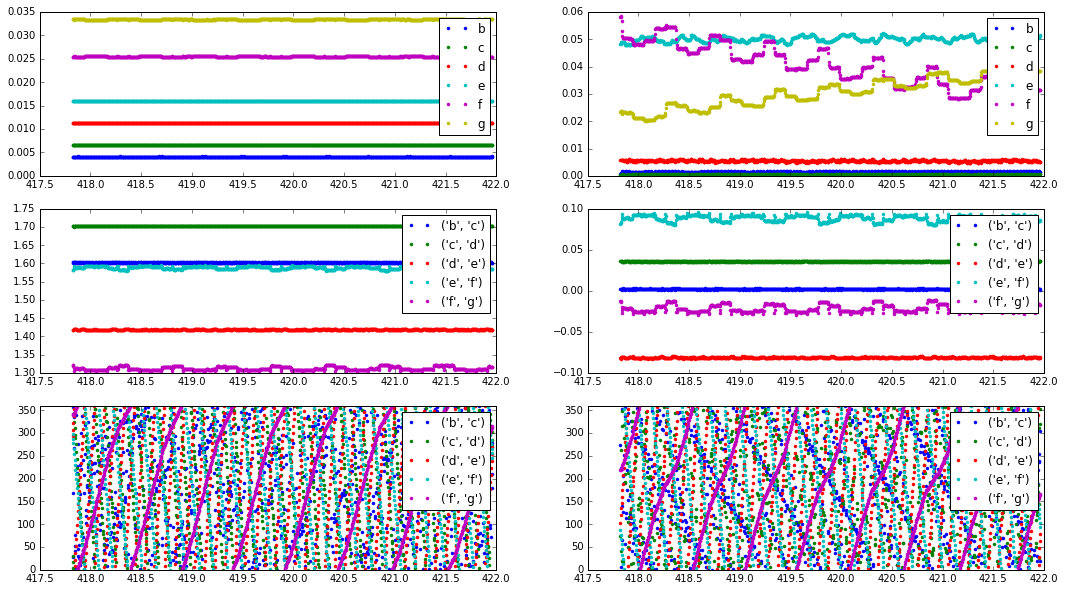

In [34]:
t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
  
integrate(sim, 1.e3*ps[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);

In [18]:
filename='data/IC{0}K{1:.4e}mag{2:.4e}.bin'.format(simID, K, mag)
sim.initSimulationArchive(filename, interval=1.e3)
sim.integrate(2.e3)

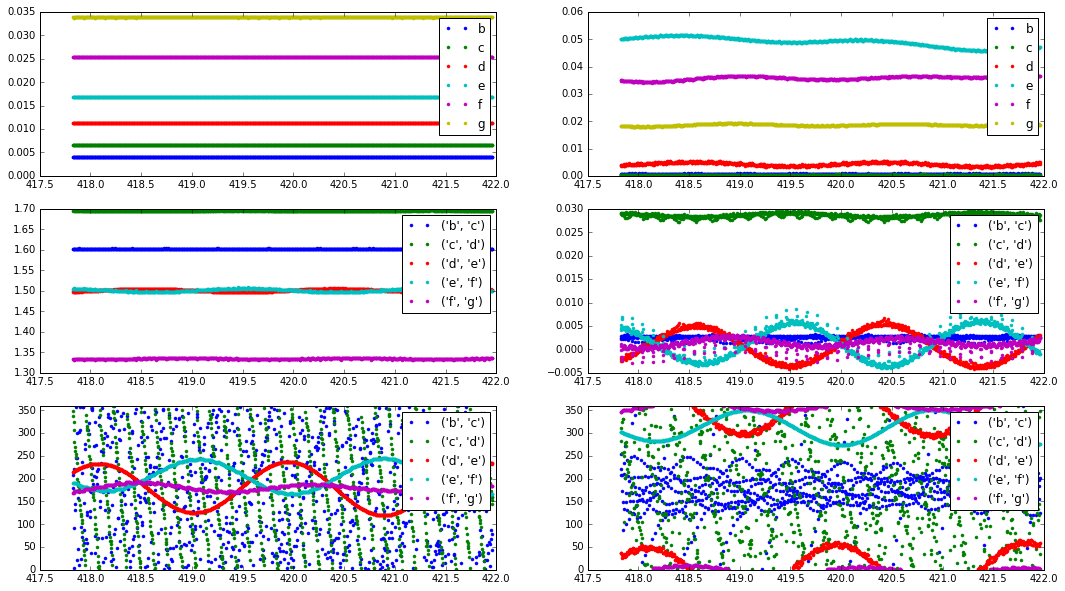

In [19]:
filename='data/IC{0}K{1:.4e}mag{2:.4e}.bin'.format(simID, K, mag)
sa = rebound.SimulationArchive(filename)
sim = sa[0]
t, e, P, pomega, longitude, Pratio, phi1, phi2 = initialize(planets, resonances)
  
integrate(sim, 1.e3*ps[1].P, t, e, P, pomega, longitude, Pratio, phi1, phi2, planets, resonances)
plot(t,P,e,Pratio,phi1,phi2,planets,resonances);